# Classifying Tweets with TensorFlow

**AIM:** To determine which Tweets are about real disasters and which one’s aren’t.

**METHOD:** We'll be using a TensorFlow's Tokenizer to make predictions.

## Importing Libraries & Exploring the Data

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)

In [2]:
# Reading in the data
orig_train = pd.read_csv('train.csv')
orig_test = pd.read_csv('test.csv')


In [3]:
orig_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
orig_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
orig_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


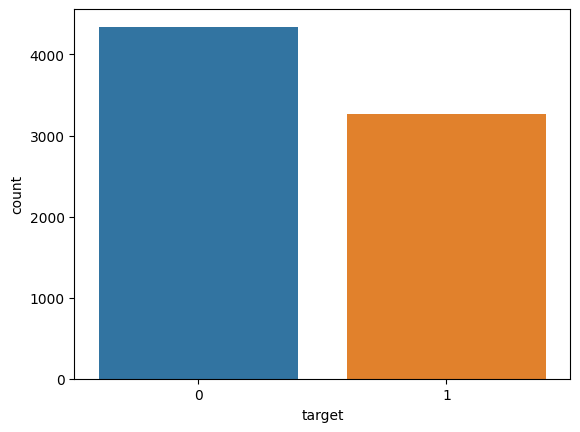

In [7]:
# Visualising the distribution of our target variable
sns.countplot(data= orig_train, x='target')
plt.show()

### Initial Observations:
- Both the test and train datasets contain a large number of null values in the `keyword` and `location` columns, with the most significant numbers in the latter.
- Tweets classified as non-disaster (0) occur more often that those classified as disaster (1); however the proportions are not concerningly off.
- Many of the values in both `location` and `keyword` include special characters instead of letters, e.g. "$" instead of "S". Some also contain coordinates instead of the location name




## Preparing our Data for the Model

In [8]:
# Isolating the target
target = orig_train['target']
ids = orig_test['id']

# Dropping the id and target columns from the datasets
new_train = orig_train.drop(['id','target'],axis=1)
new_test = orig_test.drop(['id'], axis=1)

## The Model

We are now going to start setting up the model using the Tokenizer from keras. The steps taken will be the following:
- Isolate the `text` columns from the final train and test sets. We will only be using this column from each dataset.
- Fit the tokenizer on our `train_text` data.
- Creat a list of sequences, each representing a sentence in the data.
- Pad each sequence so that they all have the same length. This length will be as long as the longest sequence in the train set.

In [9]:
# TRAIN

# Isolating the text column from the orig_train data to use with Tokenizer
train_text  = new_train['text']

# # Initializing the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()

# Fitting the tokenizer on our text
tokenizer.fit_on_texts(train_text)

# Assigning each word in a sentence aninteger with texts_to_sequences
train_seq = tokenizer.texts_to_sequences(train_text)

# Finding the maximum sequence length
seq_len_train = list(map(lambda x: len(x),train_seq))
max_len = np.max(seq_len_train)

# Standardising the list so that each list has the same length
final_train = tf.keras.preprocessing.sequence.pad_sequences(sequences=train_seq, maxlen=max_len, padding='post')

In [10]:
# TEST - Repeating the above for the test dataset

# Isolating the text column from the final_test data to use with Tokenizer
test_text  = new_test['text']

# Assigning each word in a sentence aninteger with texts_to_sequences
test_seq = tokenizer.texts_to_sequences(test_text)

# Standardising the list so that each list has the same length
final_test = tf.keras.preprocessing.sequence.pad_sequences(sequences=test_seq, maxlen=max_len, padding='post')

### Training the Model

In [11]:
# Setting up the model 
inputs = tf.keras.Input(shape=(33,))

input_shape = len(tokenizer.word_index) +1

# Creating an embedding layer 
embedding = tf.keras.layers.Embedding(
    input_dim=input_shape,
    output_dim=64)(inputs)

# Creating a flatten layer
flatten = tf.keras.layers.Flatten()(embedding)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)

# Initializing the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)

# Visualizing the summary stats
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding (Embedding)       (None, 33, 64)            1452864   
                                                                 
 flatten (Flatten)           (None, 2112)              0         
                                                                 
 dense (Dense)               (None, 1)                 2113      
                                                                 
Total params: 1454977 (5.55 MB)
Trainable params: 1454977 (5.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
# Training the model
model_fit = model.fit(
    final_train,
    target,
    validation_split=0.3,
    batch_size=12,
    epochs=100,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(       # Monitoring val_loss and with a patience of 3
                 monitor='val_loss',
                 patience=3,
                 restore_best_weights=True)
    ]
    
)

Epoch 1/100
445/445 [==============================] - 12s 26ms/step - loss: 0.5894 - accuracy: 0.6870 - val_loss: 0.5235 - val_accuracy: 0.7596
Epoch 2/100
445/445 [==============================] - 11s 25ms/step - loss: 0.3125 - accuracy: 0.8853 - val_loss: 0.4773 - val_accuracy: 0.7881
Epoch 3/100
445/445 [==============================] - 11s 26ms/step - loss: 0.1315 - accuracy: 0.9625 - val_loss: 0.4872 - val_accuracy: 0.7666
Epoch 4/100
445/445 [==============================] - 12s 26ms/step - loss: 0.0690 - accuracy: 0.9788 - val_loss: 0.5142 - val_accuracy: 0.7574
Epoch 5/100
445/445 [==============================] - 12s 27ms/step - loss: 0.0464 - accuracy: 0.9842 - val_loss: 0.5313 - val_accuracy: 0.7548


With a accuracy of 98.4%, the model seems to be performing well on the train data. Time to make predictions.

## Making Predictions

In [13]:
predictions =  model.predict(final_test)

102/102 [==============================] - 0s 2ms/step


In [14]:
# Rounding the predictons to get 0 and 1 values
predictions = np.around(np.squeeze(predictions),0).astype(int)

# Creating a series 
predictions_df = pd.DataFrame((predictions), columns=['target'])
predictions_df = pd.concat([predictions_df,ids],axis=1)
predictions_df = predictions_df[['id','target']]

### Submisson

In [15]:
submission = predictions_df.copy()
submission.to_csv('./submission.csv', index =False, header=True)

Final accuracy: 78.6%